In [1]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [2]:
import pandas as pd
from pathlib import Path

DATA_FOLDER = Path("../data")

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset.pkl")
collisions_df = collisions.drop(columns=["physicalid", "geometry"])

In [3]:
collisions_df.dropna(subset="traffic_volume", inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

collisions_train, collisions_test = train_test_split(
    collisions_df, test_size=0.2, random_state=42
)

In [38]:
import numpy as np
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy="mean", missing_values=0)
collisions_train[["st_width"]] = mean_imputer.fit_transform(
    collisions_train[["st_width"]]
)

collisions_train["has_bike_lane"] = ~(collisions_train["bike_lane"] == "nan")
collisions_train["has_parking"] = collisions_train["n_parking_meters"] > 0
collisions_train["speed_limit"] = collisions_train["speed_limit"].fillna(value=25)

is_av_mask = (
    (collisions_train["post_type"].isin(["AVE", "BLVD"]))
    | (collisions_train["pre_type"] == "AVE")
    | (collisions_train["st_name"].isin(["BROADWAY", "BOWERY"]))
)
is_st_mask = collisions_train["post_type"] == "ST"
is_rd_mask = collisions_train["post_type"].isin(["RD", "ROAD"])

collisions_train["is_av"] = is_av_mask
collisions_train["is_st"] = is_st_mask
collisions_train["is_rd"] = is_rd_mask

collisions_train["log_leng"] = np.log(collisions_train["shape_leng"])
collisions_train["log_width"] = np.log(collisions_train["st_width"])
collisions_train["inv_trees"] = 1.0 / (1 + collisions_train["n_trees"])
collisions_train["leng_per_tree"] = collisions_train["log_leng"] / (
    1 + collisions_train["n_trees"]
)
collisions_train["width_per_tree"] = collisions_train["log_width"] / (
    1 + collisions_train["n_trees"]
)
collisions_train["log_traffic_volume"] = np.log1p(collisions_train["traffic_volume"])

In [45]:
linear_reg_features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "inv_trees",
    "width_per_tree",
    "log_traffic_volume",
    "leng_per_tree",
]

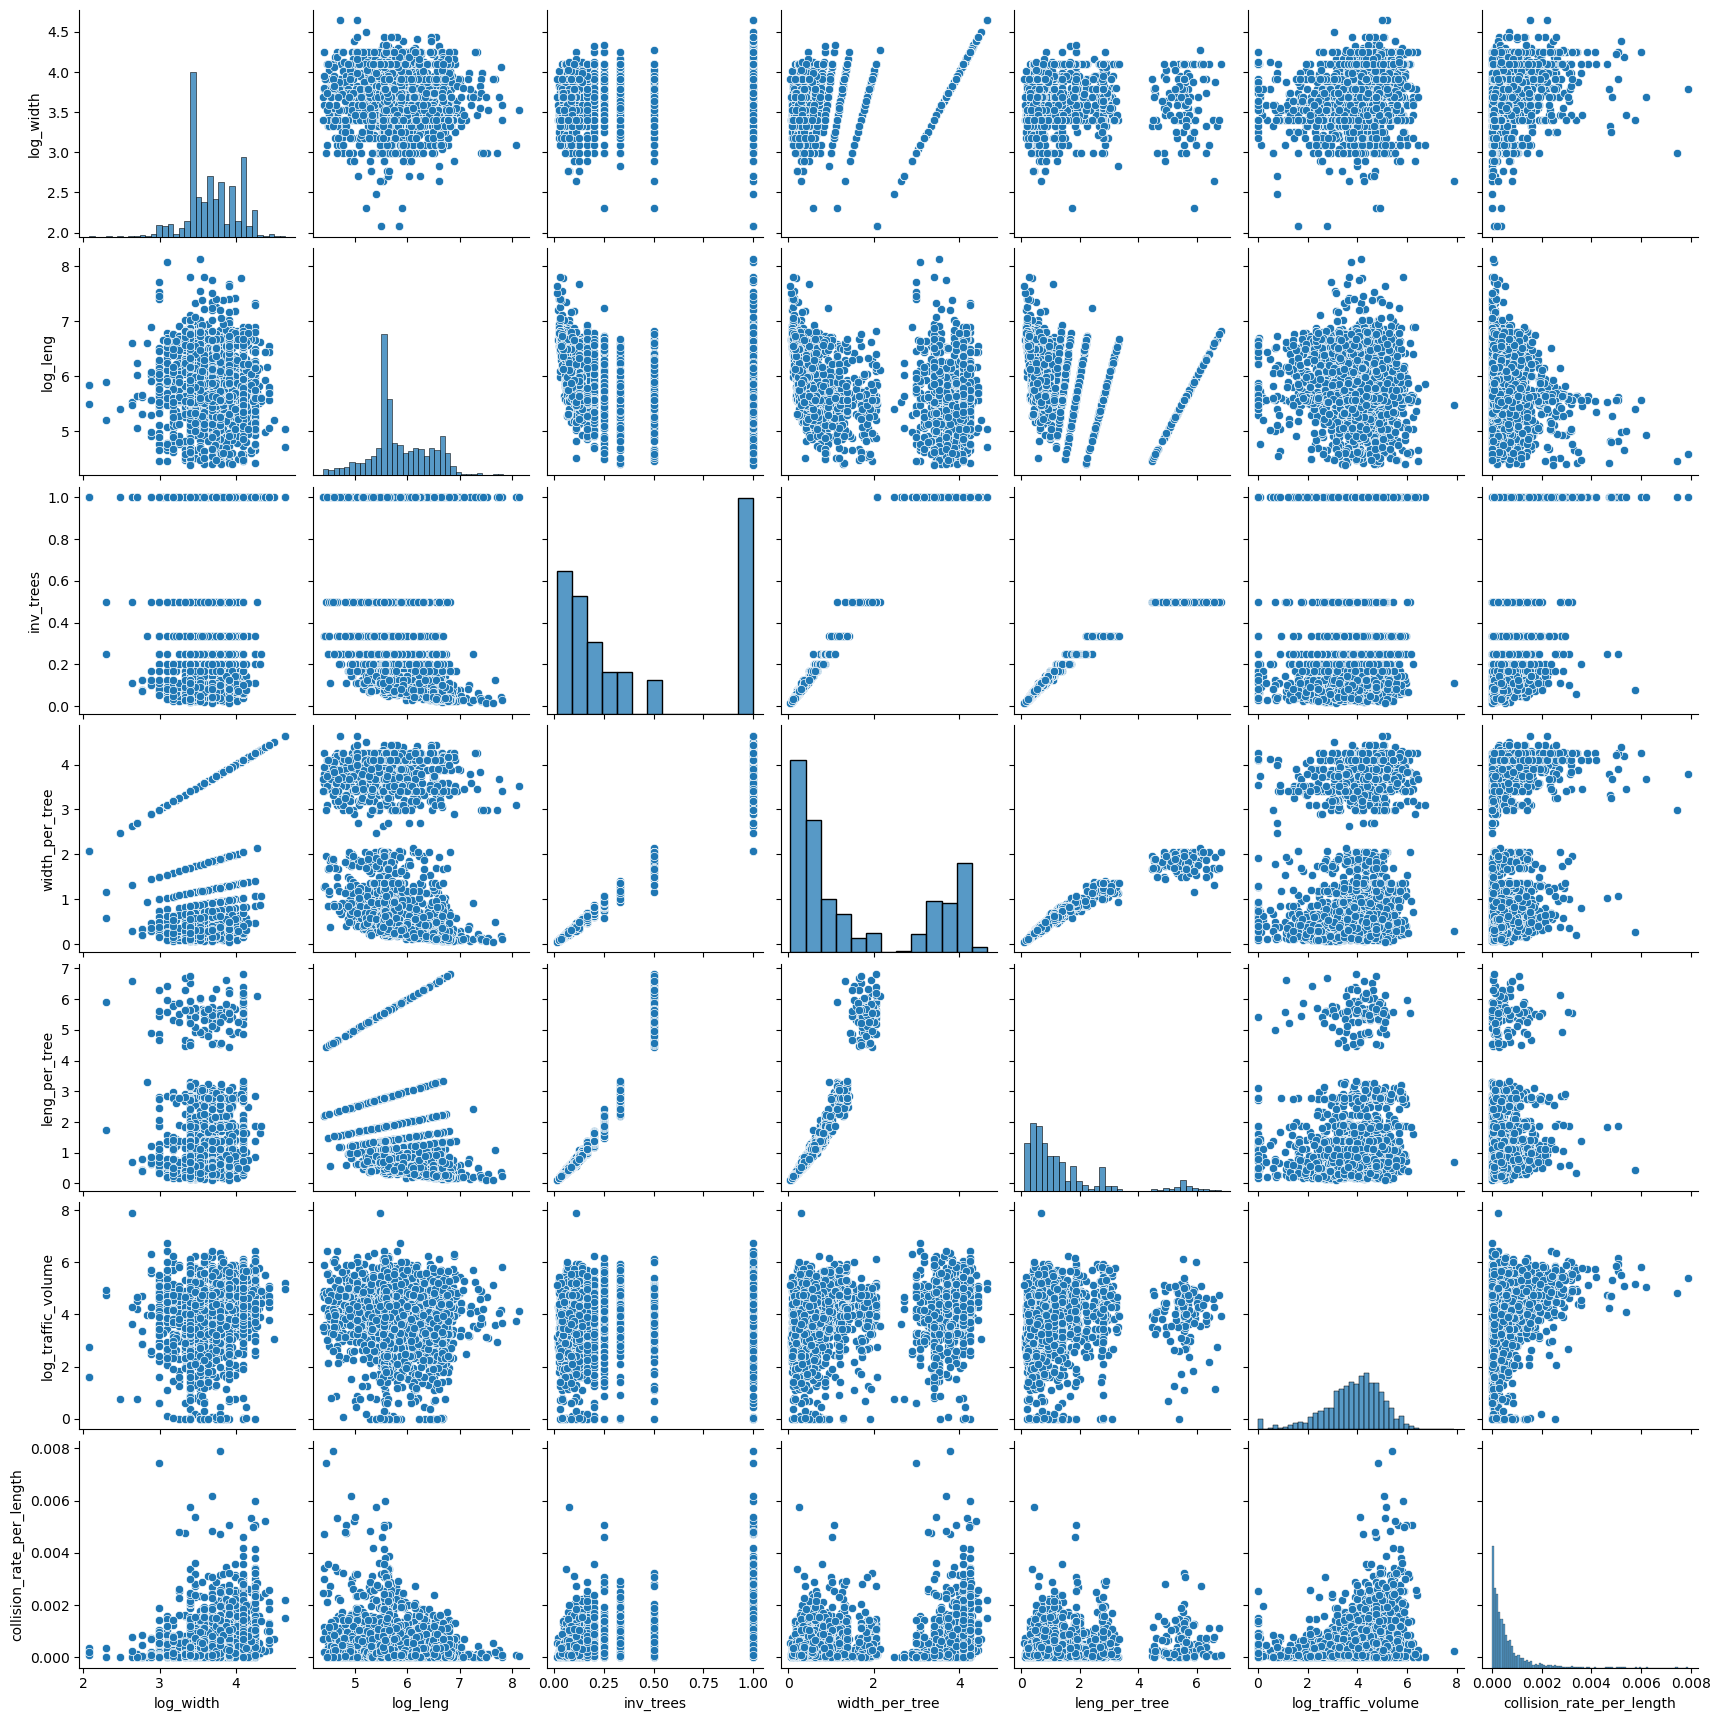

In [7]:
import seaborn as sns

cont_features = [
    "log_width",
    "log_leng",
    "inv_trees",
    "width_per_tree",
    "leng_per_tree",
    "log_traffic_volume",
]
sns.pairplot(collisions_train[cont_features + ["collision_rate_per_length"]])

In [8]:
collisions_train[linear_reg_features].corr()

,log_width,log_leng,has_humps,has_parking,has_bike_lane,is_av,is_st,is_rd,inv_trees,width_per_tree,log_traffic_volume,leng_per_tree
log_width,1.000000,-0.094488,-0.117784,0.083434,0.161482,0.197391,-0.161843,0.035092,0.272216,0.387573,0.231902,0.116146
log_leng,-0.094488,1.000000,0.138218,0.030598,-0.032548,-0.173231,0.203173,-0.029726,-0.301918,-0.297206,-0.122384,-0.352546
has_humps,-0.117784,0.138218,1.000000,-0.059851,-0.004071,-0.055889,0.082511,-0.053474,-0.141533,-0.139633,-0.106735,-0.107882
has_parking,0.083434,0.030598,-0.059851,1.000000,0.042054,0.006793,0.054914,-0.019938,-0.077669,-0.068566,0.070169,0.001728
has_bike_lane,0.161482,-0.032548,-0.004071,0.042054,1.000000,0.043924,0.016937,-0.041948,0.013389,0.030867,0.055902,0.046226
is_av,0.197391,-0.173231,-0.055889,0.006793,0.043924,1.000000,-0.672193,-0.285084,0.094800,0.114177,0.145124,0.120761
is_st,-0.161843,0.203173,0.082511,0.054914,0.016937,-0.672193,1.000000,-0.153838,-0.181233,-0.188268,-0.191376,-0.153127
is_rd,0.035092,-0.029726,-0.053474,-0.019938,-0.041948,-0.285084,-0.153838,1.000000,0.088481,0.085899,0.029647,0.053412
inv_trees,0.272216,-0.301918,-0.141533,-0.077669,0.013389,0.094800,-0.181233,0.088481,1.000000,0.988776,0.248095,0.972423
width_per_tree,0.387573,-0.297206,-0.139633,-0.068566,0.030867,0.114177,-0.188268,0.085899,0.988776,1.000000,0.264194,0.961138


In [46]:
linear_reg_features.remove("inv_trees")
linear_reg_features.remove("leng_per_tree")


X_train = collisions_train[linear_reg_features]
y_train = collisions_train["collision_rate_per_length"]

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_norm = scaler.fit_transform(X_train)

In [48]:
y_train.describe()

count    2596.000000
mean        0.000578
std         0.000741
min         0.000000
25%         0.000136
50%         0.000343
75%         0.000729
max         0.007889
Name: collision_rate_per_length, dtype: float64

### Linear regression

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

base_lin_reg_score = cross_val_score(
    lin_reg, X_norm, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [50]:
import numpy as np

-base_lin_reg_score.mean()

4.219801847760151e-07

In [19]:
lin_reg.fit(X_norm, y_train)

LinearRegression()

In [18]:
y_train.describe()

count    2596.000000
mean        0.000578
std         0.000741
min         0.000000
25%         0.000136
50%         0.000343
75%         0.000729
max         0.007889
Name: collision_rate_per_length, dtype: float64

In [25]:
import pickle
import os

os.makedirs("../models/regression", exist_ok=True)
with open("../models/regression/base_linear.pkl", "wb") as f:
    pickle.dump(lin_reg, f)

In [26]:
pd.DataFrame(lin_reg.coef_, index=X_train.columns, columns=["coefficient"])

,coefficient
log_width,0.000046
log_leng,-0.000040
has_humps,-0.000008
has_parking,0.000025
has_bike_lane,0.000005
is_av,0.000014
is_st,0.000033
is_rd,-0.000003
width_per_tree,0.000033
log_traffic_volume,0.000050


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso


def get_scores_for_lasso(X_train, y_train, features, min_alpha=0.001, max_alpha=1):
    alphas = np.linspace(min_alpha, max_alpha, 300)

    data_array = np.zeros(shape=(300, len(linear_reg_features) + 5))

    for i, alpha in enumerate(alphas):
        lasso_reg = Lasso(alpha=alpha, max_iter=10000)
        lasso_scores = cross_val_score(
            lasso_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
        )
        lasso_r2_scores = cross_val_score(
            lasso_reg, X_train, y_train, cv=5, scoring="r2"
        )
        val_r2 = lasso_r2_scores.mean()
        val_mse = -lasso_scores.mean()
        lasso_reg.fit(X_train, y_train)
        y_pred = lasso_reg.predict(X_train)
        train_mse = mean_squared_error(y_train, y_pred)
        train_r2 = r2_score(y_train, y_pred)
        data_array[i, 0] = alpha
        data_array[i, -4] = train_r2
        data_array[i, -3] = val_r2
        data_array[i, -2] = train_mse
        data_array[i, -1] = val_mse
        data_array[i, 1:-4] = lasso_reg.coef_
    columns = ["alpha"] + features + ["train_r2", "val_r2", "train_mse", "val_mse"]
    return pd.DataFrame(data_array, columns=columns)

In [20]:
lasso_scores = get_scores_for_lasso(
    X_norm, y_train, linear_reg_features, min_alpha=0.00000000001, max_alpha=0.00001
)

In [21]:
lasso_scores.head(10)

,alpha,log_width,log_leng,has_humps,has_parking,has_bike_lane,is_av,is_st,is_rd,width_per_tree,log_traffic_volume,train_r2,val_r2,train_mse,val_mse
0,1.000000e-11,0.000128,-0.000136,-0.000024,0.000095,0.000012,0.000066,0.000092,-0.000002,0.000096,0.000162,0.235049,0.234020,4.202427e-07,4.219802e-07
1,3.345478e-08,0.000128,-0.000136,-0.000024,0.000095,0.000012,0.000066,0.000092,-0.000002,0.000096,0.000162,0.235049,0.234022,4.202427e-07,4.219790e-07
2,6.689957e-08,0.000128,-0.000136,-0.000024,0.000095,0.000012,0.000066,0.000092,-0.000002,0.000096,0.000162,0.235049,0.234024,4.202427e-07,4.219779e-07
3,1.003443e-07,0.000128,-0.000136,-0.000024,0.000095,0.000012,0.000066,0.000092,-0.000002,0.000096,0.000162,0.235049,0.234027,4.202428e-07,4.219768e-07
4,1.337891e-07,0.000128,-0.000136,-0.000024,0.000095,0.000012,0.000066,0.000091,-0.000002,0.000096,0.000162,0.235048,0.234029,4.202429e-07,4.219757e-07
5,1.672339e-07,0.000128,-0.000136,-0.000024,0.000095,0.000012,0.000066,0.000091,-0.000002,0.000096,0.000162,0.235048,0.234031,4.202430e-07,4.219747e-07
6,2.006787e-07,0.000128,-0.000135,-0.000024,0.000095,0.000012,0.000066,0.000091,-0.000002,0.000096,0.000162,0.235048,0.234033,4.202431e-07,4.219737e-07
7,2.341235e-07,0.000128,-0.000135,-0.000024,0.000095,0.000012,0.000066,0.000091,-0.000002,0.000096,0.000162,0.235048,0.234035,4.202433e-07,4.219727e-07
8,2.675683e-07,0.000128,-0.000135,-0.000024,0.000095,0.000012,0.000065,0.000091,-0.000002,0.000096,0.000162,0.235047,0.234037,4.202434e-07,4.219717e-07
9,3.010130e-07,0.000128,-0.000135,-0.000024,0.000095,0.000012,0.000065,0.000091,-0.000002,0.000096,0.000161,0.235047,0.234039,4.202437e-07,4.219708e-07


In [22]:
lasso_scores.iloc[np.argmin(lasso_scores.val_mse.values)]

alpha                 7.357952e-07
log_width             1.276683e-04
log_leng             -1.350944e-04
has_humps            -2.346131e-05
has_parking           9.494968e-05
has_bike_lane         1.168799e-05
is_av                 6.401090e-05
is_st                 8.922882e-05
is_rd                -2.188524e-06
width_per_tree        9.580746e-05
log_traffic_volume    1.611758e-04
train_r2              2.350381e-01
val_r2                2.340538e-01
train_mse             4.202486e-07
val_mse               4.219644e-07
Name: 22, dtype: float64

Text(0.0, 1.0, 'Train and validation MSE against Lasso alpha')

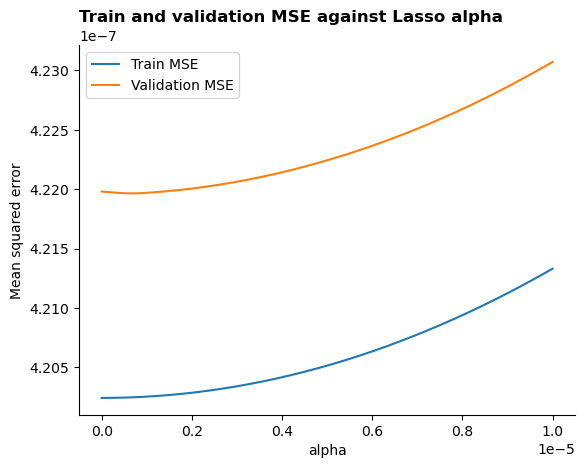

In [23]:
plt.plot(lasso_scores.alpha.values, lasso_scores.train_mse.values, label="Train MSE")
plt.plot(lasso_scores.alpha.values, lasso_scores.val_mse.values, label="Validation MSE")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.legend()
plt.title("Train and validation MSE against Lasso alpha")

**Note**: It seems that the best linear model is the base one. And we also have the MSE score to beat: $5.65\times 10^{-8}$.

### Support vector machines

In [134]:
from sklearn.svm import SVR

svr = SVR(kernel="poly", degree=2)

In [130]:
svr_reg_features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "inv_trees",
    "log_traffic_volume",
]

In [131]:
X_train = collisions_train[svr_reg_features]

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_norm = scaler.fit_transform(X_train)

In [135]:
svr.fit(X_norm, y_train)

SVR(degree=2, kernel='poly')

In [138]:
svr_deg_2_scores = cross_val_score(svr, X_norm, y_train, cv=5, scoring="r2")

In [139]:
-svr_deg_2_scores.mean()

20.627652139475813

In [142]:
from sklearn.metrics import mean_squared_error, r2_score


def get_scores_for_svr(X_train, y_train, min_alpha=0.001, max_alpha=1.0):
    cs = np.linspace(min_alpha, max_alpha, 100)

    data_array = np.zeros(shape=(100, 5))

    for i, c in enumerate(cs):
        svr_reg = SVR(C=c, kernel="poly", degree=2, max_iter=-1, epsilon=0.001)
        svr_scores = cross_val_score(
            svr_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
        )
        svr_r2_scores = cross_val_score(svr_reg, X_train, y_train, cv=5, scoring="r2")
        val_r2 = svr_r2_scores.mean()
        val_mse = -svr_scores.mean()
        svr_reg.fit(X_train, y_train)
        y_pred = svr_reg.predict(X_train)
        train_mse = mean_squared_error(y_train, y_pred)
        train_r2 = r2_score(y_train, y_pred)
        data_array[i, 0] = c
        data_array[i, -4] = train_r2
        data_array[i, -3] = val_r2
        data_array[i, -2] = train_mse
        data_array[i, -1] = val_mse
        # data_array[i, 1:-2] = svr_reg.coef_
    columns = ["C", "train_mse", "val_mse"]
    return pd.DataFrame(data_array, columns=columns)

In [143]:
scores = get_scores_for_svr(X_norm, y_train, 0.0001, 2)

In [146]:
scores

,C,train_mse,val_mse
0,0.000100,5.303933e-07,5.783654e-07
1,0.020301,6.171233e-07,6.515277e-07
2,0.040502,6.245244e-07,6.365816e-07
3,0.060703,6.585479e-07,6.541904e-07
4,0.080904,6.142839e-07,6.322116e-07
...,...,...,...
95,1.919196,6.295305e-07,6.612408e-07
96,1.939397,6.394816e-07,6.611131e-07
97,1.959598,6.491873e-07,6.666607e-07
98,1.979799,6.317082e-07,6.804775e-07


### Random forests

In [186]:
forest_features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "inv_trees",
    "log_traffic_volume",
]

In [187]:
from sklearn.preprocessing import PolynomialFeatures

deg_2_feats_transf = PolynomialFeatures(degree=2, include_bias=False)
X_train = collisions_train[forest_features]

X_train_deg_2 = deg_2_feats_transf.fit_transform(
    X_train[["log_width", "log_leng", "inv_trees", "log_traffic_volume"]]
)
new_cols = deg_2_feats_transf.get_feature_names_out()

In [188]:
X_train.loc[:, new_cols] = X_train_deg_2

In [25]:
from sklearn.ensemble import RandomForestRegressor

base_rnd_forest = RandomForestRegressor(n_estimators=500, min_samples_split=20)

In [54]:
rnd_forests_scores = cross_val_score(
    base_rnd_forest, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [55]:
-rnd_forests_scores.mean()

3.981014704266252e-07

In [72]:
from sklearn.model_selection import GridSearchCV

grid = {
    "n_estimators": [1000, 2000],
    "min_samples_split": [10, 20, 50],
}

grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True,
)

In [73]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': [10, 20, 50],
                         'n_estimators': [1000, 2000]},
             return_train_score=True, scoring='r2')

In [75]:
grid_search.best_score_

0.27580607120998574

In [76]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_split=20, n_estimators=1000)

In [58]:
import pickle

with open("../models/regression/random_forest.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

In [77]:
r2_scores = cross_val_score(
    grid_search.best_estimator_, X_train, y_train, cv=5, scoring="r2"
)

In [78]:
r2_scores.mean()

0.27422201390718404

In [79]:
grid_search.best_estimator_.feature_importances_, grid_search.best_estimator_.feature_names_in_

(array([0.15658011, 0.25398833, 0.00064016, 0.03423   , 0.00741037,
        0.00767852, 0.02331724, 0.00540171, 0.14284008, 0.36791347]),
 array(['log_width', 'log_leng', 'has_humps', 'has_parking',
        'has_bike_lane', 'is_av', 'is_st', 'is_rd', 'width_per_tree',
        'log_traffic_volume'], dtype=object))

In [152]:
from sklearn.model_selection import GridSearchCV

grid = {
    "n_estimators": [50, 100, 500, 1000],
    "min_samples_split": [10, 20, 50],
}

grid_search_2 = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True,
)

In [161]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': [10, 20, 50],
                         'n_estimators': [50, 100, 500, 1000]},
             return_train_score=True, scoring='r2')

In [166]:
pd.DataFrame(
    grid_search_2.best_estimator_.feature_importances_,
    index=grid_search_2.best_estimator_.feature_names_in_,
    columns=["importance"],
).sort_values(by="importance", ascending=False)

,importance
log_width log_traffic_volume,0.357147
log_width log_leng,0.097303
inv_trees log_traffic_volume,0.089394
log_leng log_traffic_volume,0.080179
log_leng,0.072238
log_leng^2,0.062419
log_leng inv_trees,0.042487
log_width inv_trees,0.037560
has_parking,0.031498
log_traffic_volume,0.026693


In [171]:
X_train.corr()

,log_width,log_leng,has_humps,has_parking,has_bike_lane,is_av,is_st,is_rd,inv_trees,log_traffic_volume,log_width^2,log_width log_leng,log_width inv_trees,log_width log_traffic_volume,log_leng^2,log_leng inv_trees,log_leng log_traffic_volume,inv_trees^2,inv_trees log_traffic_volume,log_traffic_volume^2
log_width,1.000000,-0.094488,-0.117784,0.083434,0.161482,0.197391,-0.161843,0.035092,0.272216,0.231902,0.997706,0.629428,0.387573,0.492051,-0.096411,0.266976,0.199845,0.261080,0.311049,0.231128
log_leng,-0.094488,1.000000,0.138218,0.030598,-0.032548,-0.173231,0.203173,-0.029726,-0.301918,-0.122384,-0.097627,0.710973,-0.297206,-0.134133,0.997603,-0.187265,0.207282,-0.243921,-0.284587,-0.136380
has_humps,-0.117784,0.138218,1.000000,-0.059851,-0.004071,-0.055889,0.082511,-0.053474,-0.141533,-0.106735,-0.119183,0.022364,-0.139633,-0.125532,0.140042,-0.135556,-0.063689,-0.123010,-0.134863,-0.116377
has_parking,0.083434,0.030598,-0.059851,1.000000,0.042054,0.006793,0.054914,-0.019938,-0.077669,0.070169,0.080318,0.084164,-0.068566,0.086036,0.025056,-0.071889,0.082395,-0.081626,-0.062559,0.061552
has_bike_lane,0.161482,-0.032548,-0.004071,0.042054,1.000000,0.043924,0.016937,-0.041948,0.013389,0.055902,0.163622,0.088555,0.030867,0.095331,-0.034280,0.010852,0.044048,0.007044,0.025585,0.049285
is_av,0.197391,-0.173231,-0.055889,0.006793,0.043924,1.000000,-0.672193,-0.285084,0.094800,0.145124,0.195513,0.004256,0.114177,0.179442,-0.174983,0.079104,0.089449,0.076888,0.119676,0.154344
is_st,-0.161843,0.203173,0.082511,0.054914,0.016937,-0.672193,1.000000,-0.153838,-0.181233,-0.191376,-0.166266,0.041436,-0.188268,-0.210637,0.203169,-0.168556,-0.126997,-0.158312,-0.192419,-0.205104
is_rd,0.035092,-0.029726,-0.053474,-0.019938,-0.041948,-0.285084,-0.153838,1.000000,0.088481,0.029647,0.035906,-0.001261,0.085899,0.034602,-0.029817,0.090271,0.017148,0.083711,0.082662,0.036022
inv_trees,0.272216,-0.301918,-0.141533,-0.077669,0.013389,0.094800,-0.181233,0.088481,1.000000,0.248095,0.292555,-0.044406,0.988776,0.304726,-0.292153,0.987762,0.146273,0.988676,0.933068,0.275345
log_traffic_volume,0.231902,-0.122384,-0.106735,0.070169,0.055902,0.145124,-0.191376,0.029647,0.248095,1.000000,0.238834,0.070329,0.264194,0.957082,-0.120143,0.241409,0.941186,0.229846,0.486969,0.966464


In [214]:
forest_features_2 = [
    "log_width log_traffic_volume",
    "log_leng log_traffic_volume",
    "log_width log_leng",
    "inv_trees log_traffic_volume",
    "log_width inv_trees",
    "log_leng",
    # "has_humps",
    "has_parking",
    # "has_bike_lane",
    # "is_av",
    "is_st",
    # "is_rd",
]

In [215]:
X_train_2 = X_train[forest_features_2].copy()

In [216]:
grid_search_2.fit(X_train_2, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': [10, 20, 50],
                         'n_estimators': [50, 100, 500, 1000]},
             return_train_score=True, scoring='r2')

In [217]:
pd.DataFrame(
    grid_search_2.best_estimator_.feature_importances_,
    index=grid_search_2.best_estimator_.feature_names_in_,
    columns=["importance"],
).sort_values(by="importance", ascending=False)

,importance
log_width log_traffic_volume,0.387677
log_leng,0.162546
inv_trees log_traffic_volume,0.117679
log_width log_leng,0.110694
log_leng log_traffic_volume,0.101806
log_width inv_trees,0.066903
has_parking,0.034721
is_st,0.017974


In [218]:
grid_search_2.best_score_

0.2537682895431936

### XGBoost

In [80]:
import xgboost

In [125]:
forest_features = [
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "leng_per_tree",
    "width_per_tree",
    "log_traffic_volume",
]

In [89]:
xgb_reg = xgboost.XGBRegressor(n_estimators=1000, max_depth=1, learning_rate=0.01)

X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size=0.1)

xgb_reg.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [127]:
grid = {
    "n_estimators": [400, 500, 800, 1000],
    "max_depth": [1, 5, 10, 20],
    "learning_rate": [0.01, 0.001, 0.0001],
}

grid_search_xgb = GridSearchCV(
    xgboost.XGBRegressor(),
    param_grid=grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True,
)

In [128]:
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001, 0.0001],
                         'max_depth': [1, 5, 10, 20],
                         'n_estimators': [400, 500, 800, 1000]},
             return_train_score=True, scoring='r2')

In [129]:
grid_search_xgb.best_score_

0.2926474233517819

In [126]:
grid_search_xgb.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
grid_search_xgb.best_estimator_.feature_importances_, grid_search_xgb.best_estimator_.feature_names_in_

(array([0.15323071, 0.10111801, 0.03058858, 0.08171758, 0.04683945,
        0.08057702, 0.1333085 , 0.02913335, 0.13283633, 0.21065047],
       dtype=float32),
 array(['log_width', 'log_leng', 'has_humps', 'has_parking',
        'has_bike_lane', 'is_av', 'is_st', 'is_rd', 'width_per_tree',
        'log_traffic_volume'], dtype='<U18'))

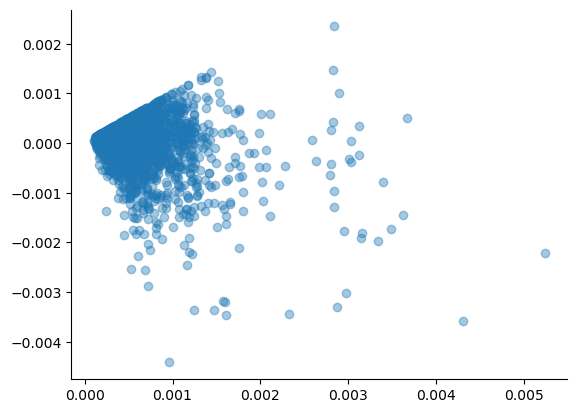

In [110]:
y_pred = grid_search_xgb.best_estimator_.predict(X_train)
residuals = y_pred - y_train
plt.scatter(y_pred, residuals, alpha=0.4)

(-0.0001, 0.003)

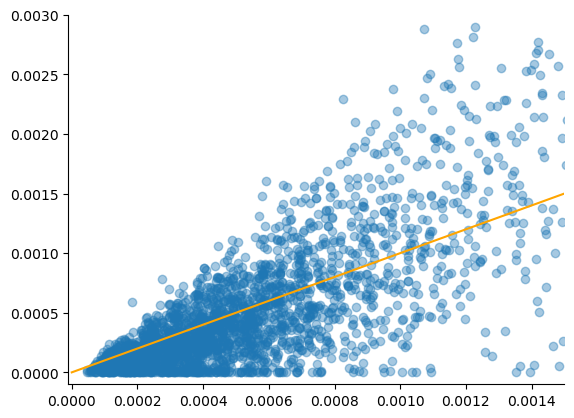

In [111]:
y_random_forest_pred = grid_search.best_estimator_.predict(X_train)
residuals = y_train - y_random_forest_pred
plt.scatter(y_random_forest_pred, y_train, alpha=0.4)
plt.plot([0, 1], [0, 1], color="orange")
plt.xlim((-0.00001, 0.00150))
plt.ylim((-0.0001, 0.003))

In [118]:
from sklearn.ensemble import VotingRegressor

voter = VotingRegressor(
    [("xgb", grid_search_xgb.best_estimator_), ("rfor", grid_search.best_estimator_)],
    weights=(0.8, 0.2),
    n_jobs=-1,
)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=400,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('rfor',
                             RandomForestRegressor(min_samples_split=20,
                                                   n_estimators=1000))],
                n_jobs=-1, weights=(0.8, 0.2))

In [119]:
scores = cross_val_score(voter, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)

In [120]:
-scores.mean()

-0.2946039636927483

In [34]:
rnd_forest = RandomForestRegressor(
    n_estimators=1000, max_depth=10, min_samples_split=20
)

In [35]:
scores = cross_val_score(rnd_forest, X_train, y_train, cv=5, scoring="r2")

In [36]:
scores.mean()

0.15493370341599888